# Analyze the results from the full connected layer model

## Import necessary modules

In [1]:
# python built-in libraries
import datetime

In [2]:
# choose the tensorflow log level
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}

In [3]:
# import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [86]:
# ohter packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from gemmi import cif

## Global Variables

In [297]:
# sampling
DATA_FILE = "./data/all_data.nc"  # path to the file of the feature tensor
FRACTIONS = (0.8, 0.1, 0.1)  # train, validation, test
BATCH_SIZE = 128  # size of the batch
BUFFER_SIZE = BATCH_SIZE * 4  # size of the shuffle buffer
RANDOM_SEED = 42  # a seed for the random sampling
THRESHOLD = 0.95
# training
LEARNING_RATE = 0.001  # starting learning rate
BETA1 = 0.9  # decay 1
BETA2 = 0.999  # decay 2
EPOCHS = 200  # number of epochs
# saving
TIME_STAMP = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # time stamp
MODEL_NAME = "C4D4"  # name of the model
MODEL_FILE = "./data/models/C4D4_20210928-190611/"  # model file
EVAL_FILE = "./data/evaluation/C4D4_20210928-190611.nc"
TEST_DS_FILE = "./data/evaluation/C4D4_20210928-190611_test_ds.nc"
# matplotlib colors
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Obtain data

The data is a 209 data point PDF. The label is a one-hot 2 dim vector. `10` means major phase >= threshold, `01` means major phase <= threshold.

In [6]:
def load_data():
    # load
    ds = xr.open_dataset(DATA_FILE)
    features = ds["G"].data
    # label the data by threshold
    single = np.array([1, 0])
    mulitple = np.array([0, 1])
    labels = np.apply_along_axis(lambda tup: single if np.max(tup) >= THRESHOLD else mulitple, 1,  ds["fraction"].values)
    # shuffle
    n = features.shape[0]
    np.random.seed(RANDOM_SEED)
    shuffled_idx = np.random.permutation(n)
    features, labels = features[shuffled_idx], labels[shuffled_idx]
    # split
    f0, f1, f2 = FRACTIONS
    i, j, k = round(f0 * n), round((f0 + f1) * n), round((f0 + f1 + f2) * n)
    test_data = tf.data.Dataset.from_tensor_slices((features[j:k], labels[j:k])).batch(BATCH_SIZE)
    # get the test data set
    test_ds = ds.isel({"mixture": shuffled_idx[j:k]}).compute()
    # close dataset
    ds.close()
    return test_ds, test_data

In [7]:
test_ds, test_data = load_data()

# Load the model

In [8]:
model = keras.models.load_model(MODEL_FILE)

# Visualize the model and the optimization

## The model

## The optimization

# Evaluate the model

### Run

In [10]:
evaluation = model.evaluate(x=test_data, return_dict=True)

86/86 [==============================] - 13s 11ms/step - loss: 0.3279 - cosine_similarity: 0.9092 - categorical_accuracy: 0.8921


In [11]:
evaluation = xr.Dataset(evaluation)

In [12]:
evaluation.to_netcdf(EVAL_FILE, engine="h5netcdf")

## Show

In [13]:
evaluation = xr.load_dataset(EVAL_FILE,  engine="h5netcdf")

In [14]:
evaluation.to_array().to_series()

variable
categorical_accuracy    0.892091
cosine_similarity       0.909195
loss                    0.327871
dtype: float64

# Evaludate the statistics of prediction

## Run

In [15]:
def one_hot_encoder(labels):
    single = np.array([1, 0])
    mulitple = np.array([0, 1])
    return np.apply_along_axis(lambda tup: single if np.max(tup) >= THRESHOLD else mulitple, 1, labels)


def one_hot_decoder(labels):
    return np.argmax(labels, axis=1)


def one_hot_decorder_xarr(labels):
    return xr.DataArray(
        one_hot_decoder(labels.values),
        dims=["mixture"]
    )


def to_catalog(prediction):
    return np.round(prediction)


def get_label(test_ds):
    return xr.DataArray(one_hot_encoder(test_ds["fraction"].values), dims=["mixture", "label"])


def predict(model, test_data):
    pred = model.predict(x=test_data)
    pred = xr.DataArray(pred, dims=["mixture", "label"])
    return pred


def add_predict(test_ds, model, test_data):
    pred = predict(model, test_data)
    one_hot_pred = to_catalog(pred)
    one_hot_label = get_label(test_ds)
    categorical_accuracy = xr.DataArray(
        np.sum(one_hot_pred.values * one_hot_label.values, axis=-1, dtype=int),
        dims=["mixture"]
    )
    cosine_similarity = xr.DataArray(
        np.sum(pred.values * one_hot_label.values, axis=-1, dtype=float),
        dims=["mixture"]
    )
    return test_ds.assign(
        {
            "prediction": pred, 
            "one_hot_prediction": one_hot_pred, 
            "one_hot_label": one_hot_label,
            "predicted_label": one_hot_decorder_xarr(one_hot_pred),
            "actual_label": one_hot_decorder_xarr(one_hot_label),
            "categorical_accuracy": categorical_accuracy,
            "cosine_similarity": cosine_similarity
        }
    )

In [16]:
eval_ds = add_predict(test_ds, model, test_data)

In [17]:
eval_ds.to_netcdf(TEST_DS_FILE, engine="h5netcdf")

## Visualize

In [49]:
eval_ds = xr.load_dataset(TEST_DS_FILE, engine="h5netcdf")

In [315]:
class Visualizor:
    
    def __init__(self, dataset: xr.Dataset):
        self.dataset = dataset
        
    def plot_hist(self, metric: str, *args, **kwargs):
        return self.dataset[metric].plot.hist(*args, **kwargs)
    
    def plot_bar(self, key: str, *args, **kwargs):
        grouped = self.dataset.groupby(key)
        nums = np.asarray([len(val) for val in grouped.groups.values()])
        names = np.asarray(list(grouped.groups.keys()))
        da = xr.DataArray(nums, {key: names}, dims=[key])
        return da.to_series().plot.bar()
    
    def plot_label_bar(self, key: str, labels: list, *args, **kwargs):
        grouped = self.dataset.groupby(key)
        nums = np.asarray([len(val) for val in grouped.groups.values()])
        idxs = np.asarray(list(grouped.groups.keys()))
        names = [labels[idx] for idx in idxs]
        da = xr.DataArray(nums, {key: names}, dims=[key])
        return da.to_series().plot.bar()
    
    def set_space_group_number(self, stru: str, sgn: str) -> None:
        
        def get_space_group_number(cif_str):
            doc = cif.Document()
            doc.parse_string(cif_str)
            return int(doc[0].find_value("_symmetry_Int_Tables_number"))
        
        sgn_arr = xr.apply_ufunc(
            np.vectorize(get_space_group_number),
            self.dataset[stru]
        )
        
        self.dataset = self.dataset.assign({sgn: sgn_arr})
        return
    
    def plot_space_group_hist(self, stru: str, sgn: str, *args, **kwargs):
        kwargs.setdefault("bins", np.arange(0.5, 230.50001, 1))
        if sgn not in self.dataset:
            self.set_space_group_number(stru, sgn)
        return self.plot_hist(sgn, *args, **kwargs)
        
    def plot_grouped_space_group_hist(
        self, 
        stru: str, 
        sgn: str, 
        correctness: str,
        *args,
        size: float = 4.,
        **kwargs
    ):
        kwargs.setdefault("bins", np.arange(0.5, 230.50001, 1))
        if sgn not in self.dataset:
            self.set_space_group_number(stru, sgn)
        groups = self.dataset.groupby(correctness).groups
        n = len(groups)
        fig, axes = plt.subplots(1, n, figsize=(n * size * 4 / 3, 1 * size))
        for i, (c, idxs) in enumerate(groups.items()):
            sel_ds = self.dataset.isel({self.dataset[correctness].dims[0]: idxs})
            sel_ds[sgn].plot.hist(*args, **kwargs, ax=axes[i])
            axes[i].set_title("Accuracy = {}".format(c))
        return fig, axes
        
    def set_major_fraction(self, fraction: str, major_fraction: str):
        fraction_data = self.dataset[fraction]
        major_fraction_data = xr.apply_ufunc(
            lambda x: np.max(x, axis=-1),
            fraction_data,
            input_core_dims=[[fraction_data.dims[-1]]]
        )
        self.dataset = self.dataset.assign({major_fraction: major_fraction_data})
        return
        
    def plot_hist_major_fraction(self, fraction: str, major_fraction: str, *args, **kwargs):
        step = 0.025
        kwargs.setdefault("bins", np.arange(0.45 - step / 2, 1.00001 + step / 2, step))
        kwargs.setdefault("align", "mid")
        if major_fraction not in self.dataset:
            self.set_major_fraction(fraction, major_fraction)
        return self.plot_hist(major_fraction, *args, **kwargs)
    
    def get_colors(self):
        return plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    def plot_hist_grouped_major_fraction(
        self, 
        fraction: str, 
        major_fraction: str, 
        correctness: str,
        *args,
        size: float = 4.,
        threshold: float = THRESHOLD,
        **kwargs
    ):
        step = 0.025
        kwargs.setdefault("bins", np.arange(0.45 - step / 2, 1.00001 + step / 2, step))
        kwargs.setdefault("align", "mid")
        if major_fraction not in self.dataset:
            self.set_major_fraction(fraction, major_fraction)
        groups = self.dataset.groupby(correctness).groups
        n = len(groups)
        fig, axes = plt.subplots(1, n, figsize=(n * size * 4 / 3, 1 * size))
        colors = self.get_colors()
        for i, (c, idxs) in enumerate(groups.items()):
            sel_ds = self.dataset.isel({self.dataset[correctness].dims[0]: idxs})
            mfv = sel_ds[major_fraction].values
            sel_ds[major_fraction].plot.hist(*args, **kwargs, ax=axes[i])
            
            axes[i].set_title("Accuracy = {}".format(c))
        return fig, axes

In [316]:
vis = Visualizor(eval_ds)

### Distribution of the single and multiple phase in test dataset

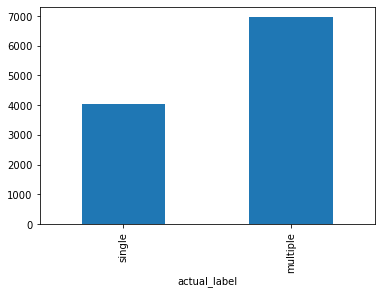

In [317]:
vis.plot_label_bar("actual_label", ["single", "multiple"]);

### Bar plot of the catalogical accuracy

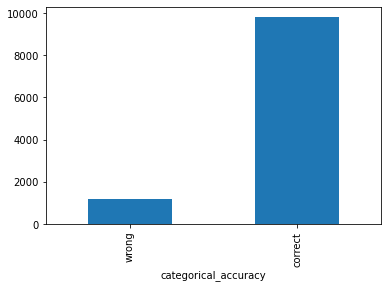

In [318]:
vis.plot_label_bar("categorical_accuracy", ["wrong", "correct"]);

### Distributon of the cosine similarity

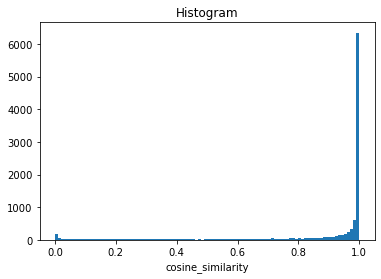

In [319]:
vis.plot_hist("cosine_similarity", bins=np.arange(0., 1.0001, 0.01));

### Relation bewteen the accuracy and the major phase fraction

Interestingly, when the major phase is around 0.8 and 0.95, it is hard to distinguish that it is a sinlge phase or mulitphase. It is probably because it is close to the threshold.

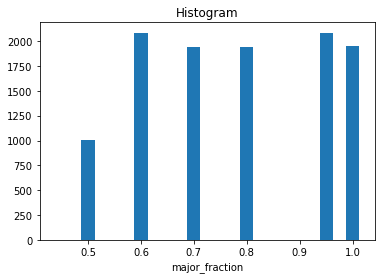

In [320]:
vis.plot_hist_major_fraction("fraction", "major_fraction");

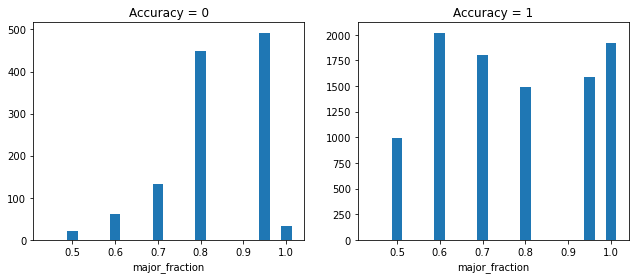

In [321]:
vis.plot_hist_grouped_major_fraction("fraction", "major_fraction", "categorical_accuracy");

### Relation between the the space group and accuracy

#### Space group of all the phases

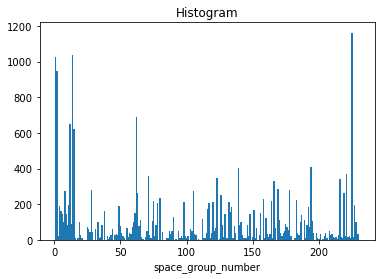

In [322]:
vis.plot_space_group_hist("structure", "space_group_number");

#### Space group of the correct prediction and the wrong prediction

There is no distinct difference in space groups distribution of the correctly catalogized data and mistakenly catalogized data.

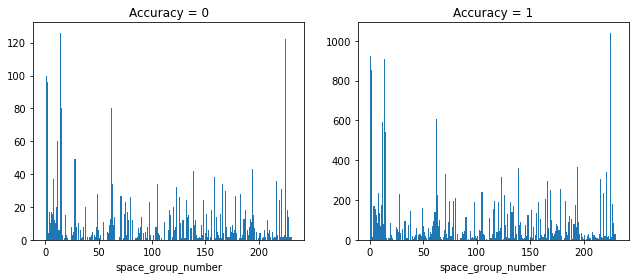

In [323]:
vis.plot_grouped_space_group_hist("structure", "space_group_number", "categorical_accuracy");